In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from matplotlib import pyplot as plt
import sys
import numpy as np
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error

sys.path.append("../../pauli_lindblad_per/")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

%load_ext autoreload
%autoreload 2


In [15]:
inst_map = [0,1,2,3]
n = 4
qc = QuantumCircuit(n)
qc.cx(1,2)
print(qc.draw())

coupling_list = [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)]



# Fehlerdefinition: Nur XX auf Qubits 1 & 2
errorops = [Pauli("XY")]
errorprobs = [0.2]

# Erzeuge PauliError und NoiseModel
twoqubit_error = pauli_error([(op, p) for op, p in zip(errorops, errorprobs)] + [(Pauli("II"), 1 - sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

backend = GenericBackendV2(num_qubits=4, coupling_map=coupling_list)
connectivity = backend.coupling_map.graph.subgraph(inst_map)
backend._sim = AerSimulator(noise_model=noise_model)

          
q_0: ─────
          
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


In [16]:
experiment = tomography(
    circuits = [qc], #list of circuits from which to get the layers requiring tomography
    inst_map = inst_map, #which physical qubits on the processor to map the qubits in the circuit
    backend = backend #quantum backend
    )

experiment._procspec.meas_bases
print(len(experiment._procspec.model_terms))

experiment.generate(
    samples = 100, #Number of samples to take from the fidelity pair measurements
    single_samples = 250, #samples to take from the pair-breaking measurements
    depths = [2,4,16,32,64] #values of 2n to make the pair measurements. Numbers must be even and non-zero
    )

shots = 1024
def executor(circuits):
    return backend.run(circuits, shots = shots).result().get_counts()

#run the experiment
experiment.run(executor)

39


In [17]:
noisedataframe = experiment.analyze()
print("noise coefficients:", list(noisedataframe.noisemodels.values())[0].coeffs)
print("spam coefficients:", list(zip(noisedataframe.spam.keys(), noisedataframe.spam.values())))

noise coefficients: [(XYII, np.float64(0.0)), (IYYI, np.float64(0.0)), (XZII, np.float64(1.6877393670385932e-07)), (ZIII, np.float64(0.0)), (IIXI, np.float64(0.0)), (IYXI, np.float64(2.8623227688421385e-06)), (IIIY, np.float64(0.0)), (IIXY, np.float64(0.0)), (YIII, np.float64(0.0)), (IIIZ, np.float64(0.0)), (IXYI, np.float64(0.0)), (ZXII, np.float64(0.0)), (IZII, np.float64(0.0)), (IYZI, np.float64(0.0)), (YYII, np.float64(0.0)), (IIZI, np.float64(0.0)), (IIZX, np.float64(0.0)), (YZII, np.float64(1.687739367038582e-07)), (IZZI, np.float64(0.0)), (XXII, np.float64(0.0)), (IIYY, np.float64(0.0)), (IZXI, np.float64(0.0)), (YXII, np.float64(0.0)), (XIII, np.float64(0.0)), (IYII, np.float64(0.0)), (IXII, np.float64(0.0)), (IIZZ, np.float64(0.0)), (IXXI, np.float64(0.0)), (IIYI, np.float64(0.0)), (IZYI, np.float64(0.0)), (IIXX, np.float64(0.0)), (IXZI, np.float64(0.0)), (ZYII, np.float64(0.0)), (IIZY, np.float64(0.0)), (IIYX, np.float64(0.0)), (IIYZ, np.float64(0.0)), (IIIX, np.float64(0.0))

[[IYYI, IYXI, IXYI, IYZI, IZZI, IZXI, IXXI, IZYI, IXZI]]


<Axes: >

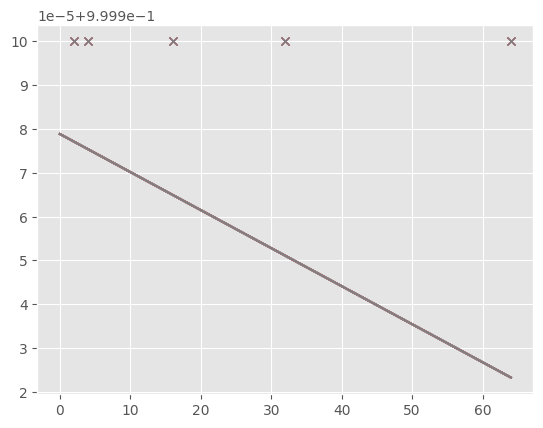

In [18]:
#The exponential decay shows that the channel was properly diagonalized
layer = experiment.analysis.get_layer_data(0)
print(layer._model_terms([(1,2)]))
layer.graph([1,2])
#print(layer)

In [28]:
from importlib import reload
import tomography.layernoisedata

reload(tomography.layernoisedata)

<module 'tomography.layernoisedata' from 'c:\\Users\\kchar\\OneDrive\\Desktop\\Uni\\Hiwi_Orth\\Qiskit\\UpdatedCode\\tomography\\layernoisedata.py'>

In [29]:
#plot the infidelities of different Paulis
layer.plot_infidelitites(plot_style = 2)

AttributeError: 'ProcessorSpec' object has no attribute 'processor'

In [ ]:
#plot the lambda_k for different terms
layer.plot_coeffs([1,2])